<a href="https://colab.research.google.com/github/Arijit-datascience/CIFAR10_Image_Recognition/blob/main/CIFAR10_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Advanced Convolutions

A. Target

change the code such that it uses GPU
change the architecture to C1C2C3C40 (basically 3 MPs)
total RF must be more than 44
one of the layers must use Depthwise Separable Convolution
one of the layers must use Dilated Convolution
use GAP (compulsory):- add FC after GAP to target #of classes (optional)
achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M.
B. Results

Parameters: 815,200
Best Training Accuracy in 20 epochs: 87.72%
Best Test Accuracy in 20 epochs: 85.09 %
Total RF reached: 76*76 at the end of Conv block 4
C. Analysis

Model meets all the mentioned targets. I have used the Depthwise seprable con and dialted kernel in the conv block 3. Also, As train test gap was coming more in earlier versions, I have used the horizontal flip and random rotations to act as regulaizer and reduce the train test gap. Code is modularized and uploaded as package in git repo.

In [1]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

In [2]:
!git clone https://github.com/Arijit-datascience/CIFAR10_Image_Recognition

Cloning into 'CIFAR10_Image_Recognition'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [3]:
from CIFAR10_Image_Recognition.dataset import dataset as dataset
from CIFAR10_Image_Recognition.models import model as models
from CIFAR10_Image_Recognition.models import train as train
from CIFAR10_Image_Recognition.models import test as test
from CIFAR10_Image_Recognition.plots_accuracy import plots as utils

In [4]:
norm_mean,norm_std = dataset.cifar10_mean_std()


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_transform, test_transform = dataset.get_transforms(norm_mean,norm_std)

(0.49, 0.48, 0.45) (0.25, 0.24, 0.26)


In [6]:
# Extract and transform the data
train_set,test_set = dataset.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Data Exploration

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

Displaying 10 images


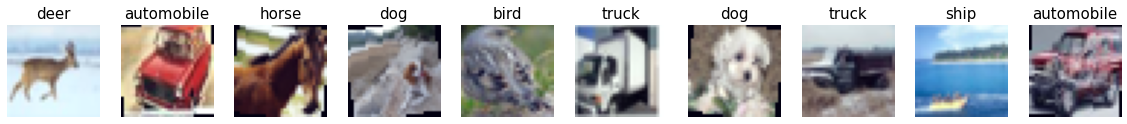

In [7]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

Import Model and show model summary

In [8]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 34, 34]           2,048
        MaxPool2d-10           [-1, 32, 18, 18]               0
           Conv2d-11           [-1, 64, 18, 18]          18,432
             ReLU-12           [-1, 64, 18, 18]               0
      BatchNorm2d-13           [-1, 64, 18, 18]             128
          Dropout-14           [-1

## Train and Test

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test.test(model, device, test_loader, test_losses, test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.3514807224273682 Batch_id=390 Train Accuracy=46.34: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1958, Test Accuracy: 5760/10000 (57.60%)

EPOCH: 1


Loss=1.215243935585022 Batch_id=390 Train Accuracy=61.50: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0101, Test Accuracy: 6409/10000 (64.09%)

EPOCH: 2


Loss=0.8892525434494019 Batch_id=390 Train Accuracy=67.63: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8905, Test Accuracy: 6902/10000 (69.02%)

EPOCH: 3


Loss=0.5487362146377563 Batch_id=390 Train Accuracy=71.91: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7290, Test Accuracy: 7428/10000 (74.28%)

EPOCH: 4


Loss=0.6710411310195923 Batch_id=390 Train Accuracy=74.56: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7000, Test Accuracy: 7594/10000 (75.94%)

EPOCH: 5


Loss=0.6739271283149719 Batch_id=390 Train Accuracy=76.53: 100%|██████████| 391/391 [00:20<00:00, 18.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6330, Test Accuracy: 7859/10000 (78.59%)

EPOCH: 6


Loss=0.6611430644989014 Batch_id=390 Train Accuracy=78.10: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5989, Test Accuracy: 8000/10000 (80.00%)

EPOCH: 7


Loss=0.5037003755569458 Batch_id=390 Train Accuracy=79.28: 100%|██████████| 391/391 [00:21<00:00, 18.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5678, Test Accuracy: 8084/10000 (80.84%)

EPOCH: 8


Loss=0.7451580166816711 Batch_id=390 Train Accuracy=80.11: 100%|██████████| 391/391 [00:20<00:00, 18.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5620, Test Accuracy: 8058/10000 (80.58%)

EPOCH: 9


Loss=0.5051788091659546 Batch_id=390 Train Accuracy=81.13: 100%|██████████| 391/391 [00:21<00:00, 18.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5220, Test Accuracy: 8178/10000 (81.78%)

EPOCH: 10


Loss=0.3397497534751892 Batch_id=390 Train Accuracy=84.54: 100%|██████████| 391/391 [00:21<00:00, 18.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4687, Test Accuracy: 8374/10000 (83.74%)

EPOCH: 11


Loss=0.28760960698127747 Batch_id=390 Train Accuracy=85.44: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4592, Test Accuracy: 8444/10000 (84.44%)

EPOCH: 12


Loss=0.427748441696167 Batch_id=390 Train Accuracy=85.87: 100%|██████████| 391/391 [00:21<00:00, 18.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4589, Test Accuracy: 8435/10000 (84.35%)

EPOCH: 13


Loss=0.30844080448150635 Batch_id=390 Train Accuracy=85.99: 100%|██████████| 391/391 [00:21<00:00, 18.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4597, Test Accuracy: 8433/10000 (84.33%)

EPOCH: 14


Loss=0.5332675576210022 Batch_id=390 Train Accuracy=86.18: 100%|██████████| 391/391 [00:20<00:00, 18.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Test Accuracy: 8473/10000 (84.73%)

EPOCH: 15


Loss=0.44449901580810547 Batch_id=390 Train Accuracy=86.68: 100%|██████████| 391/391 [00:20<00:00, 19.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4496, Test Accuracy: 8476/10000 (84.76%)

EPOCH: 16


Loss=0.42172878980636597 Batch_id=390 Train Accuracy=86.77: 100%|██████████| 391/391 [00:20<00:00, 18.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4490, Test Accuracy: 8484/10000 (84.84%)

EPOCH: 17


Loss=0.2951611876487732 Batch_id=390 Train Accuracy=86.80: 100%|██████████| 391/391 [00:20<00:00, 18.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4437, Test Accuracy: 8520/10000 (85.20%)

EPOCH: 18


Loss=0.35373130440711975 Batch_id=390 Train Accuracy=87.11: 100%|██████████| 391/391 [00:20<00:00, 18.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4494, Test Accuracy: 8474/10000 (84.74%)

EPOCH: 19


Loss=0.3410390615463257 Batch_id=390 Train Accuracy=86.98: 100%|██████████| 391/391 [00:20<00:00, 18.86it/s]



Test set: Average loss: 0.4537, Test Accuracy: 8506/10000 (85.06%)



## Validation accuracy and Loss curves

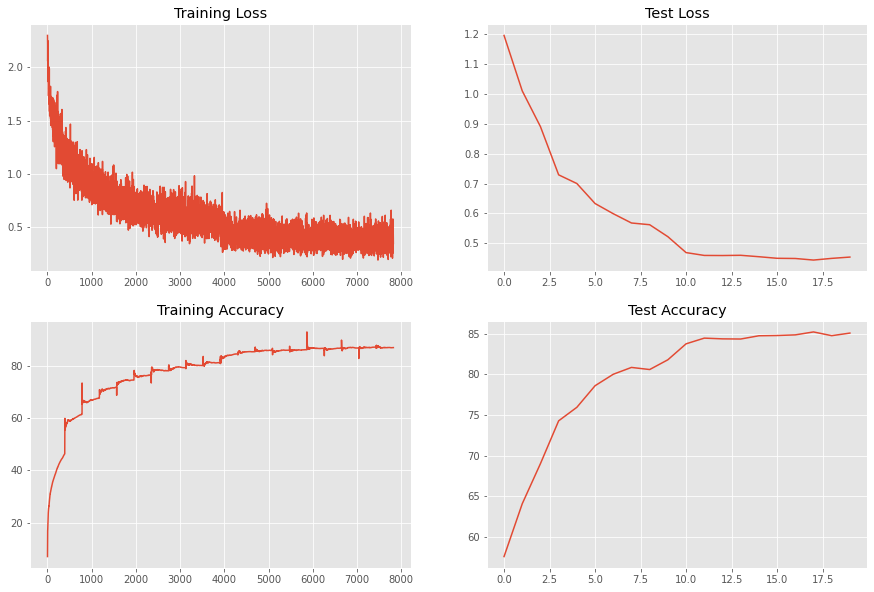

In [10]:
utils.valid_accuracy_loss_plots(train_losses, train_acc, test_losses, test_acc)

## Display misclassified images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

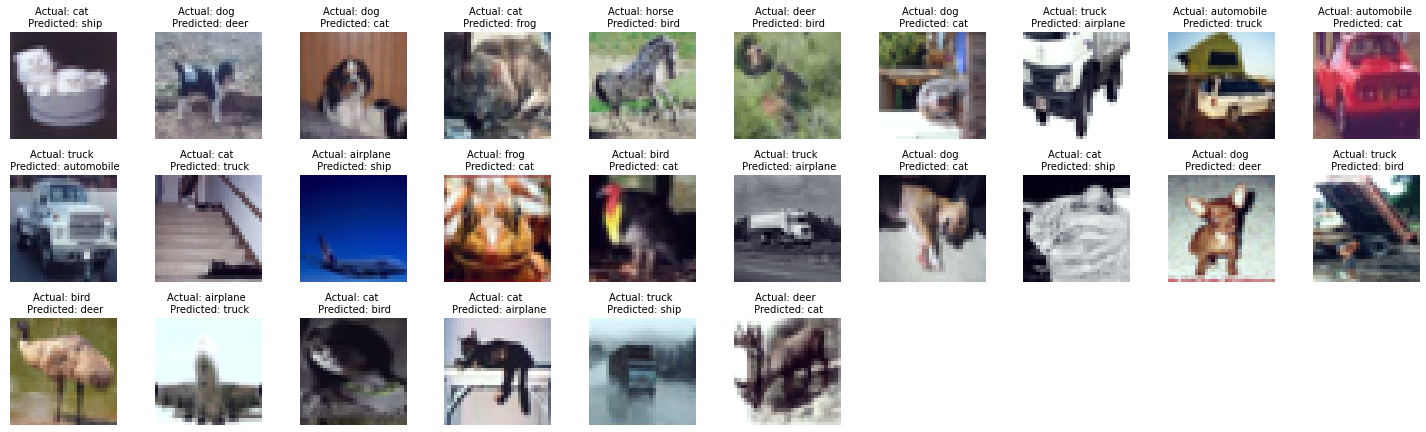

In [11]:
utils.show_misclassified_images(model, classes, test_loader, num_of_images = 25)